In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.55_.85',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_1e-24',
                          'crd_a3d1611',
                          'atmpro_saw')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.55_.85',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_1e-24',
                          'crd_a3d1611',
                          'atmpro_saw')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 800

nband = 180

nv = 200

dv = 0.005

tsfc = 257.0

ng = 3

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 3 /)

data wgt
     &     /.5, .55, .85/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 1

klin = 1e-24

include 'saw75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

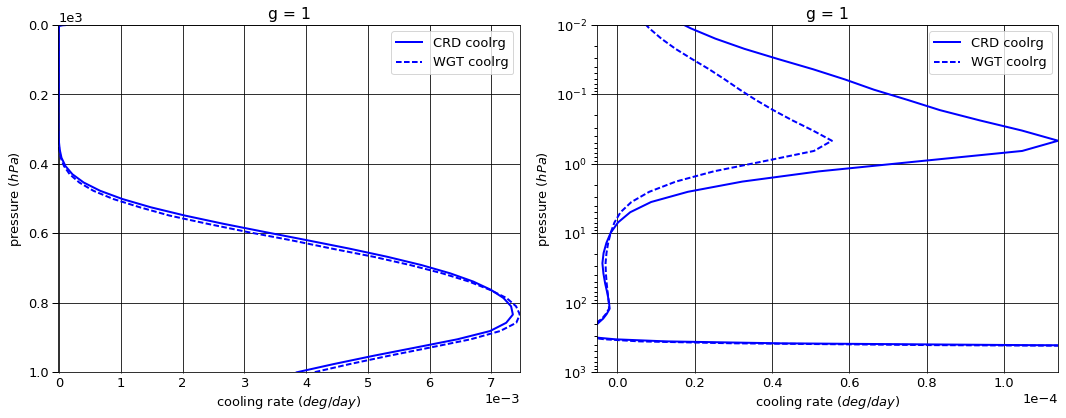

# Figure: cooling rate g-group 2

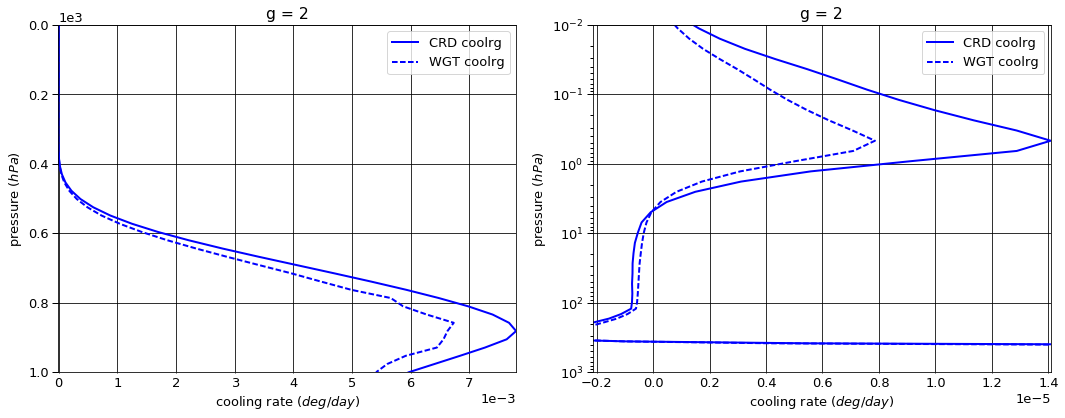

# Figure: cooling rate g-group 3

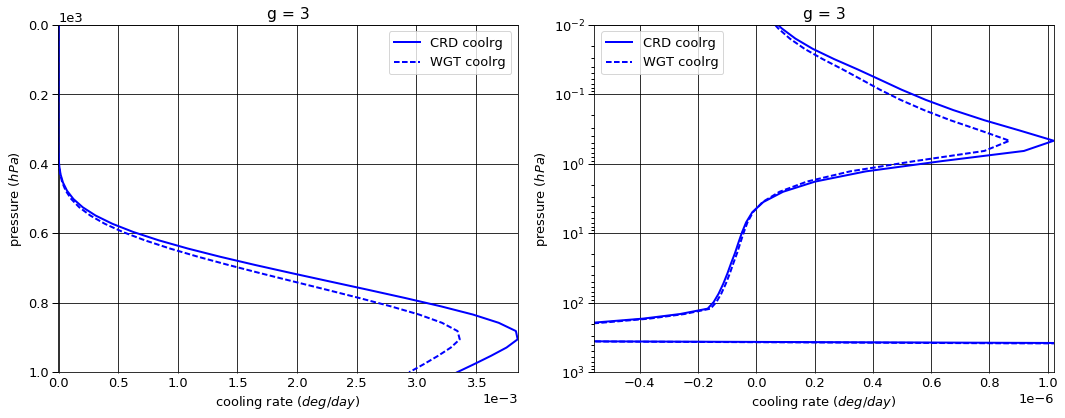

# Figure: cooling rate g-group total

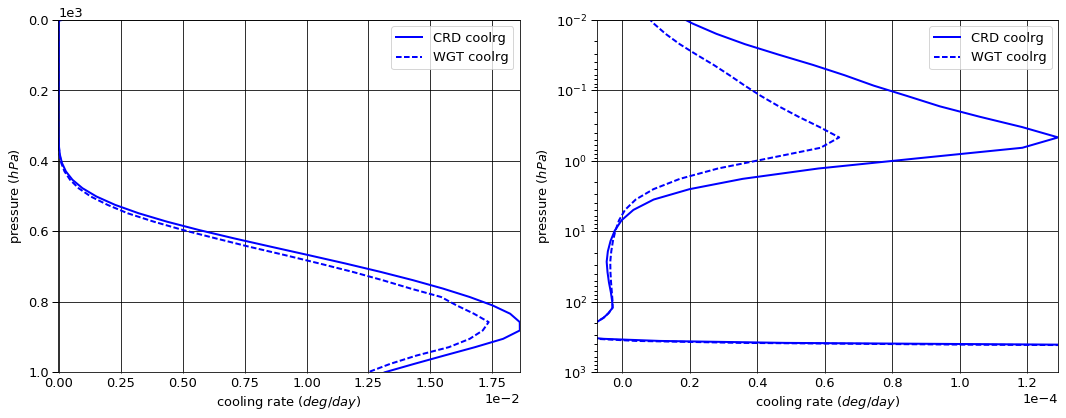

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.660363  0.000000  -0.660363
  1013.0   76     -0.685307  0.344714  -0.340593
2 0.0      1      -2.846556  0.000000  -2.846556
  1013.0   76     -2.856831  0.303276  -2.553556
3 0.0      1     -29.318357  0.000000 -29.318357
  1013.0   76    -29.321628  0.140677 -29.180951


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.662951  0.000000  -0.662951
  1013.0   76     -0.685307  0.340032  -0.345275
2 0.0      1      -2.848322  0.000000  -2.848322
  1013.0   76     -2.856831  0.260039  -2.596793
3 0.0      1     -29.318772  0.000000 -29.318772
  1013.0   76    -29.321628  0.122522 -29.199107


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002588  0.000000 -0.002588
  1013.0   76     0.000000 -0.004683 -0.004683
2 0.0      1     -0.001766  0.000000 -0.001766
  1013.0   76     0.000000 -0.043237 -0.043237
3 0.0      1     -0.000415  0.000000 -0.000415
  1013.0   76     0.000000 -0.018156 -0.018156

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.627515e-06
  1001.112500 75     3.848974e-03
2 0.000312    1     -9.575540e-07
  1001.112500 75     5.964491e-03
3 0.000312    1     -5.081850e-08
  1001.112500 75     3.341759e-03


WGT


coolrg
g pressure    layer              
1 0.000312    1     -3.017599e-06
  1001.112500 75     4.128764e-03
2 0.000312    1     -5.533957e-07
  1001.112500 75     5.409859e-03
3 0.000312    1     -4.226869e-08
  1001.112500 75     2.939977e-03


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.609916e-06
  1001.112500 75     2.797902e-04
2 0.000312    1      4.041584e-07
  1001.112500 75    -5.546317e-04
3 0.000312    1      8.549804e-09
  1001.112500 75    -4.017812e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.825276,0.000000,-32.825276
1013.0,76,-32.863766,0.788667,-32.075099



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.830045,0.000000,-32.830045
1013.0,76,-32.863766,0.722592,-32.141175



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.004769,0.000000,-0.004769
1013.0,76,0.000000,-0.066075,-0.066076


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.013155



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.000004
1001.112500,75,0.012479



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000002
1001.112500,75,-0.000677


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.019389,0.020953
2,0.084389,0.087107
3,0.896222,0.891940


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.191856e-23
2,1.000925e-24
3,2.367330e-27


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.191856e-23,NaN,0.019389,0.020953,0.019389,0.020953,600.0
2,1.000925e-24,0.083980,0.084389,0.087107,0.103778,0.108060,600.0
3,2.367330e-27,0.002365,0.896222,0.891940,1.000000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog       ratio
layer g                                                     
1     1     0.000312  1.621090e-23  5.426360e-25   29.874351
      2     0.000312  5.032652e-25  1.371556e-26   36.693014
      3     0.000312  2.315043e-27  2.501890e-29   92.531763
2     1     0.000750  1.689336e-23  5.492098e-25   30.759395
      2     0.000750  5.201294e-25  1.390761e-26   37.398916
      3     0.000750  2.435237e-27  2.560873e-29   95.094007
3     1     0.001052  1.836056e-23  5.621171e-25   32.663235
      2     0.001052  5.569294e-25  1.428082e-26   38.998430
      3     0.001052  2.699190e-27  2.676802e-29  100.836370
4     1     0.001476  1.997536e-23  5.749754e-25   34.741242
      2     0.001476  5.983165e-25  1.464769e-26   40.847158
      3     0.001476  2.998506e-27  2.799824e-29  107.096260
5     1     0.002070  2.173041e-23  5.876547e-25   36.978186
      2     0.002070  6.443993e-25  1.500924e-26   42.933506
      3     0.002070  3.334229e-27  2.930053e-29  113.794160
6     1     0.002904  2.363676e-23  6.001659e-25   39.383719
      2     0.002904  6.957935e-25  1.537301e-26   45.260722
      3     0.002904  3.711125e-27  3.069551e-29  120.901240
7     1     0.004074  2.570630e-23  6.125123e-25   41.968618
      2     0.004074  7.531904e-25  1.574710e-26   47.830426
      3     0.004074  4.134647e-27  3.221179e-29  128.358200
8     1     0.005714  2.795204e-23  6.247107e-25   44.743972
      2     0.005714  8.173745e-25  1.613917e-26   50.645388
      3     0.005714  4.611110e-27  3.388996e-29  136.061230
9     1     0.008015  3.038732e-23  6.368137e-25   47.717752
      2     0.008015  8.892052e-25  1.655610e-26   53.708625
      3     0.008015  5.147626e-27  3.578783e-29  143.837320
10    1     0.011243  3.302700e-23  6.489537e-25   50.892686
      2     0.011243  9.696599e-25  1.700511e-26   57.021660
      3     0.011243  5.752504e-27  3.799032e-29  151.420230
11    1     0.015771  3.588643e-23  6.613883e-25   54.259254
      2     0.015771  1.059811e-24  1.749563e-26   60.575788
      3     0.015771  6.435186e-27  4.062357e-29  158.410150
12    1     0.022122  3.898187e-23  6.745645e-25   57.788208
      2     0.022122  1.160846e-24  1.804200e-26   64.341322
      3     0.022122  7.206527e-27  4.387765e-29  164.241390
13    1     0.031031  4.231506e-23  6.891496e-25   61.401846
      2     0.031031  1.273541e-24  1.866481e-26   68.232192
      3     0.031031  8.074933e-27  4.802948e-29  168.124510
14    1     0.043528  4.548420e-23  7.050883e-25   64.508516
      2     0.043528  1.384300e-24  1.934209e-26   71.569332
      3     0.043528  8.937807e-27  5.322505e-29  167.924820
15    1     0.061057  4.807788e-23  7.227252e-25   66.523035
      2     0.061057  1.477404e-24  2.006274e-26   73.639166
      3     0.061057  9.672710e-27  5.966697e-29  162.111640
16    1     0.085645  5.042468e-23  7.445867e-25   67.721712
      2     0.085645  1.563437e-24  2.092686e-26   74.709575
      3     0.085645  1.036147e-26  6.816458e-29  152.006670
17    1     0.120136  5.286441e-23  7.737390e-25   68.323312
      2     0.120136  1.654633e-24  2.205970e-26   75.007035
      3     0.120136  1.110220e-26  7.985080e-29  139.036750
18    1     0.168516  5.540918e-23  8.131395e-25   68.142276
      2     0.168516  1.751558e-24  2.357224e-26   74.305949
      3     0.168516  1.190347e-26  9.598653e-29  124.011860
19    1     0.236378  5.806008e-23  8.666529e-25   66.993463
      2     0.236378  1.854345e-24  2.561210e-26   72.401122
      3     0.236378  1.277209e-26  1.182809e-28  107.981010
20    1     0.331549  6.081588e-23  9.392108e-25   64.752116
      2     0.331549  1.962990e-24  2.837280e-26   69.185626
      3     0.331549  1.371602e-26  1.490069e-28   92.049575
21    1     0.465100  6.337574e-23  1.035382e-24   61.210031
      2     0.465100  2.065009e-24  3.202607e-26   64.479002
      3     0.465100  1.464304e-26  1.904266e-28   76.895985
22    1     0.652400  6.125108e-23  1.132493e-2

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
